# Image data sets

In [2]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import corner
import logging
from sklearn.decomposition import PCA
import torch
from torch import nn

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)

sys.path.append("../../")
from experiments.datasets import CelebALoader, ImageNetLoader



## Plotting function

In [3]:
def show_images(dataset, n=20, return_array=10000, train=True):
    if dataset == "celeba":
        loader = CelebALoader()
    elif dataset == "imagenet":
        loader = ImageNetLoader()
    else:
        raise ValueError(dataset)
        
    data = loader.load_dataset(train=train, dataset_dir="../data/samples/{}".format(dataset))
    
    fig = plt.figure(figsize=(5*3., 4*3.))
    
    for i in range(n):
        x, _ = data[np.random.randint(len(data) - 1)]
        x_ = np.transpose(np.array(x), [1,2,0]) / 256.
        ax = plt.subplot(4, 5, i+1)
        plt.imshow(x_)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.tight_layout()
    plt.show()
    
    return np.array([data[i][0].numpy() for i in range(return_array)])
    

## ImageNet

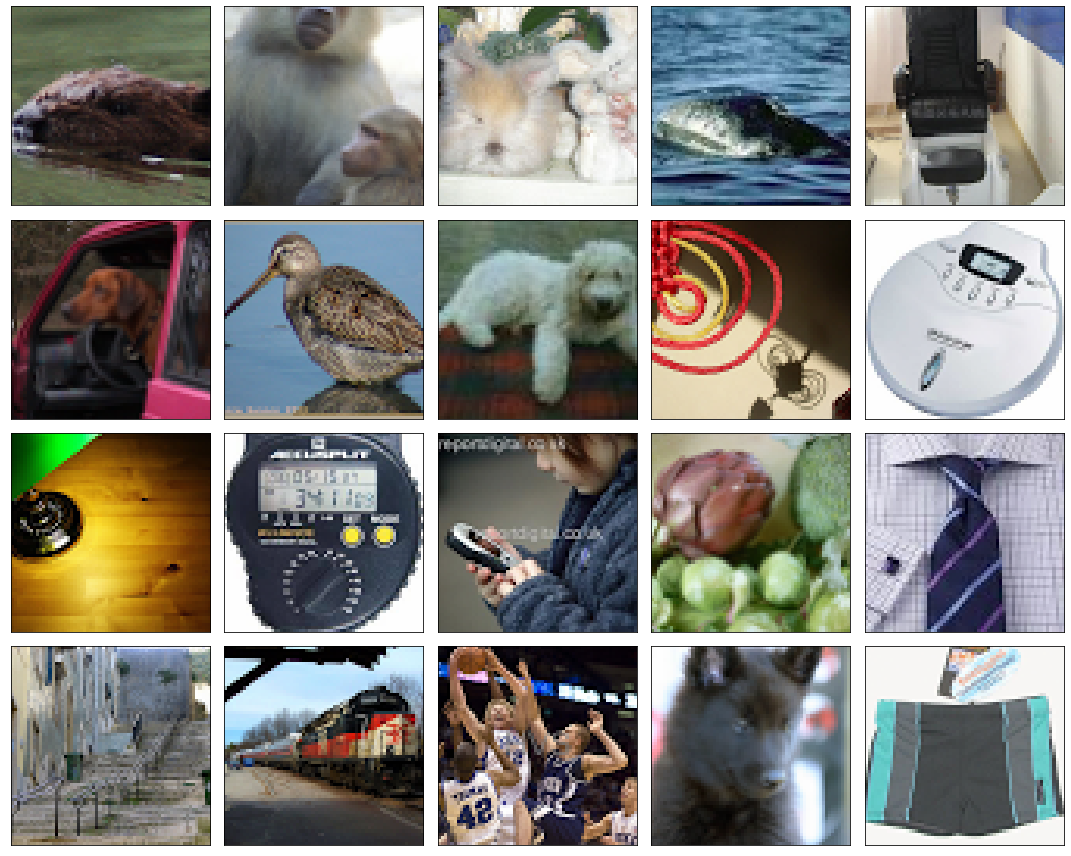

In [4]:
x_imagenet = show_images("imagenet")

## CelebA

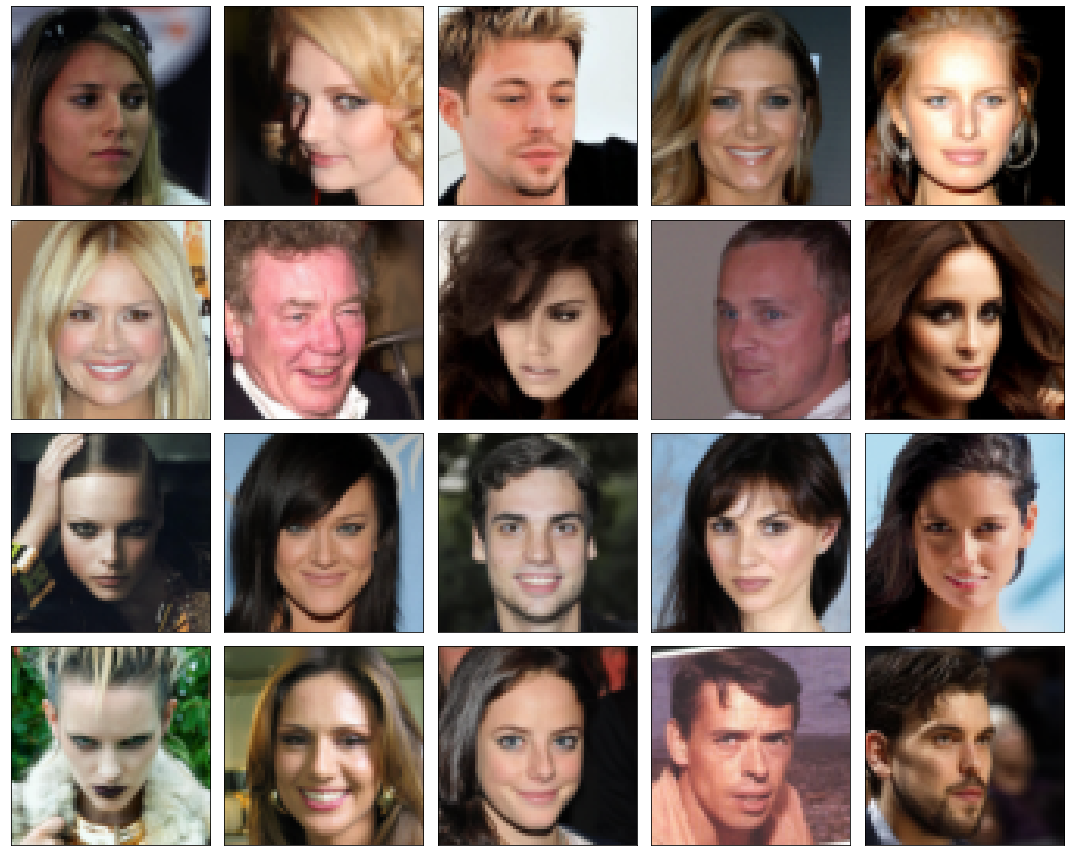

In [5]:
x_celeba = show_images("celeba")

## PCA

In [ ]:
pca_celeba = PCA(n_components=1000)
pca_celeba.fit(x_celeba.reshape((10000, -1)))
exvar_celeba = pca_celeba.explained_variance_ratio_


In [ ]:
pca_imagenet = PCA(n_components=1000)
pca_imagenet.fit(x_imagenet.reshape((10000, -1)))
exvar_imagenet = pca_imagenet.explained_variance_ratio_


In [ ]:
plt.figure(figsize=(5,5))

plt.plot(np.arange(1, 1001), 1. - np.cumsum(exvar_imagenet), label="ImageNet")
plt.plot(np.arange(1, 1001), 1. - np.cumsum(exvar_celeba), label="CelebA")

plt.legend()

plt.ylim(0.,None)
plt.xlabel("PCA components")
plt.ylabel("Unexplained fraction of variance")

plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(5,5))

plt.plot(np.arange(1, 1001), exvar_imagenet, label="ImageNet")
plt.plot(np.arange(1, 1001), exvar_celeba, label="CelebA")

plt.legend()

plt.ylim(0.,None)
plt.xlabel("PCA component")
plt.ylabel("Explained fraction of variance")
plt.yscale("log")
plt.ylim(0.00001,1.)

plt.tight_layout()
plt.show()


## Autoencoders

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, dim):
        super(AutoEncoder, self).__init__()
        
        self.conv_encoder = nn.Sequential(              # (b,  3, 64, 64)
            nn.Conv2d(3,16, kernel_size=5, stride=1),   # (b, 16, 60, 60)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),                  # (b, 16, 30, 30)
            nn.Conv2d(16, 64, kernel_size=5, stride=1), # (b, 64, 26, 26)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),                  # (b, 64, 13, 13)
        )
        self.fc_encoder = nn.Sequential(
            nn.Linear(64*13*13, 1000),
            nn.ReLU(True),
            nn.Linear(1000, dim),
            nn.ReLU(True),
        )
        self.fc_decoder = nn.Sequential(
            nn.Linear(dim, 1000),
            nn.ReLU(True),
            nn.Linear(1000, 64*13*13),
            nn.ReLU(True),
        )
        self.conv_decoder = nn.Sequential(                                  # (b, 64, 13, 13)          
            nn.ConvTranspose2d(64,32, kernel_size=5, stride=2, padding=0),  # (b, 32, 29, 29) 
            nn.ReLU(True),
            nn.ConvTranspose2d(32,16, kernel_size=4, stride=2, padding=0),  # (b, 16, 60, 60) 
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, kernel_size=5, stride=1, padding=0),  # (b,  3, 64, 64)
        )

    def forward(self, x):
        x = self.conv_encoder(x)
        x = x.view((x.size(0), -1))
        x = self.fc_encoder(x)
        x = self.fc_decoder(x)
        x = x.view((x.size(0), 64, 13, 13))
        x = self.conv_decoder(x)
        return x

In [ ]:
def train(dim, epochs=10, batchsize=100, lr=3.e-4, wdecay=1.e-4):
    dataset = CelebALoader().load_dataset(train=True, dataset_dir="../data/samples/celeba")
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True, num_workers=4)
    model = AutoEncoder(dim)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wdecay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        total_loss = 0.
        for data in dataloader:
            x, _ = data
            x_reco = model(x)
            loss = criterion(x_reco, x)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step(epoch)
            total_loss += loss.item()
            
        print('Epoch {}: reco error = {:.4f}'.format(epoch+1, total_loss / len(dataloader)))
    
    return model

In [ ]:
def evaluate(model, batchsize=100):
    dataset = CelebALoader().load_dataset(train=False, dataset_dir="../data/samples/celeba")
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True, num_workers=4)
    criterion = nn.MSELoss()
    
    model.eval()
    total_loss = 0.
    
    with torch.no_grad():
        for batch, data in enumerate(dataloader):
            x, _ = data
            x_reco = model(x)
            total_loss += criterion(x_reco, x).item()
            
            if batch > 0:
                continue
                
            fig = plt.figure(figsize=(6*3., 5*3.))
            for i in range(15):
                ax = plt.subplot(5, 6, 2*i+1)
                x_ = np.transpose(np.array(x[i]), [1,2,0]) / 256.
                plt.imshow(x_)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                
                ax = plt.subplot(5, 6, 2*i+2)
                x_reco_ = np.transpose(np.array(x_reco[i]), [1,2,0]) / 256.
                plt.imshow(x_reco_)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

            plt.tight_layout()
            plt.show()
            
    return total_loss / len(dataloader)
        

In [ ]:
models = {}
errors = {}

In [ ]:
models[1000] = train(1000)
evaluate(models[1000])

In [ ]:
models[100] = train(100)
evaluate(models[100])

In [ ]:
models[10] = train(10)
errors[10] = evaluate(models[10])

In [ ]:
models[500] = train(500)
evaluate(models[500])

In [ ]:
models[200] = train(200)
evaluate(models[200])

In [ ]:
models[50] = train(50)
evaluate(models[50])

In [ ]:
models[20] = train(20)
errors[20] = evaluate(models[20])